## Diabetic Retinopathy

In this kernel we wil use Convolutional Neural Networks to predict the probability that wether a person is suffering from DIabteic Retinopathy or not using the sample images provided to us in the dataset.

**Diabetic retinopathy** is a diabetes complication that affects eyes. It's caused by damage to the blood vessels of the light-sensitive tissue at the back of the eye (retina). At first, diabetic retinopathy may cause no symptoms or only mild vision problems.

![image.png](attachment:image.png)

You might not have symptoms in the early stages of diabetic retinopathy. As the condition progresses, diabetic retinopathy symptoms may include:

* Spots or dark strings floating in your vision (floaters)
* Blurred vision
* Fluctuating vision
* Impaired color vision
* Dark or empty areas in your vision
* Vision loss
* Diabetic retinopathy usually affects both eyes.

**Diabetic retinopathy can lead to other serious eye conditions:** 

1. Diabetic macular edema (DME). Over time, about half of people with diabetic retinopathy will develop DME. DME happens when blood vessels in the retina leak fluid, causing swelling in the macula (a part of the retina). If you have DME, your vision will become blurry because of the extra fluid in your macula.  

2. Neovascular glaucoma. Diabetic retinopathy can cause abnormal blood vessels to grow out of the retina and block fluid from draining out of the eye. This causes a type of glaucoma.

Diabetic retinopathy is caused by high blood sugar due to diabetes. Over time, having too much sugar in your blood can damage your retina — the part of your eye that detects light and sends signals to your brain through a nerve in the back of your eye (optic nerve).  



Diabetes damages blood vessels all over the body. The damage to your eyes starts when sugar blocks the tiny blood vessels that go to your retina, causing them to leak fluid or bleed. To make up for these blocked blood vessels, your eyes then grow new blood vessels that don’t work well. These new blood vessels can leak or bleed easily. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

 99% 1.92G/1.94G [00:42<00:00, 48.1MB/s]
100% 1.94G/1.94G [00:42<00:00, 49.3MB/s]


In [ ]:
! unzip diabetic-retinopathy-2015-data-colored-resized

Streaming output truncated to the last 5000 lines.
  inflating: colored_images/colored_images/No_DR/4632_left.png  
  inflating: colored_images/colored_images/No_DR/4632_right.png  
  inflating: colored_images/colored_images/No_DR/4633_right.png  
  inflating: colored_images/colored_images/No_DR/4641_left.png  
  inflating: colored_images/colored_images/No_DR/4641_right.png  
  inflating: colored_images/colored_images/No_DR/4642_left.png  
  inflating: colored_images/colored_images/No_DR/4642_right.png  
  inflating: colored_images/colored_images/No_DR/4649_left.png  
  inflating: colored_images/colored_images/No_DR/4649_right.png  
  inflating: colored_images/colored_images/No_DR/4652_left.png  
  inflating: colored_images/colored_images/No_DR/4652_right.png  
  inflating: colored_images/colored_images/No_DR/4658_left.png  
  inflating: colored_images/colored_images/No_DR/4658_right.png  
  inflating: colored_images/colored_images/No_DR/4659_left.png  
  inflating: colored_images/colo

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Add, AveragePooling2D, Dense, AvgPool2D, BatchNormalization, ReLU, DepthwiseConv2D, Reshape, Permute,Conv2D, MaxPool2D, GlobalAveragePooling2D, concatenate, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

### Using the Image Data Generator 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )
train_data = datagen.flow_from_directory('colored_images/colored_images/',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('colored_images/colored_images/',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 28103 images belonging to 5 classes.
Found 7023 images belonging to 5 classes.


## Defining the learning rate scheduler

In [ ]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [ ]:
checkpoint_path = "training/shufflenet_cp_{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
def channel_shuffle(x, groups):  
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups

    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [ ]:
def shuffle_unit(x, groups, channels,strides):

    y = x
    x = Conv2D(channels//4, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)
    
    x = DepthwiseConv2D(kernel_size = (3,3), strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)

    if strides == (2,2):
        channels = channels - y.shape[-1]
    x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)

    if strides ==(1,1):
        x =Add()([x,y])
    if strides == (2,2):
        y = AvgPool2D((3,3), strides = (2,2), padding = 'same')(y)
        x = concatenate([x,y])
    
    x = ReLU()(x)


    return x

In [ ]:
def Shuffle_Net(nclasses, start_channels ,input_shape = (224,224,3)):

    groups = 2
    input = Input (input_shape)

    x =  Conv2D (24,kernel_size=3,strides = (2,2), padding = 'same', use_bias = True)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPool2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    for i,repetition in enumerate(repetitions):
        channels = start_channels * (2**i)

        x  = shuffle_unit(x, groups, channels,strides = (2,2))

        for i in range(repetition):
            x = shuffle_unit(x, groups, channels,strides=(1,1))

    x = GlobalAveragePooling2D()(x)

    output = Dense(n_classes,activation='softmax')(x)

    model = Model(input, output)
    return model

In [ ]:
n_classes = 5
input_shape = (224,224,3)
start_channels = 200

In [ ]:
model = Shuffle_Net(n_classes, start_channels, input_shape)
    
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
for layer in model.layers[:-22]:
    layer.trainable = False

In [ ]:

history = model.fit(train_data,validation_data = valid_data,callbacks=[lr_callback, cp_callback],epochs=35,verbose=1)


Epoch 1/35
879/879 [==============================] - 521s 573ms/step - loss: 0.8926 - acc: 0.7329 - val_loss: 0.8772 - val_acc: 0.7350 - lr: 1.0000e-04
Epoch 2/35
879/879 [==============================] - 491s 558ms/step - loss: 0.8732 - acc: 0.7341 - val_loss: 0.9091 - val_acc: 0.7349 - lr: 1.0000e-04
Epoch 3/35
879/879 [==============================] - 487s 554ms/step - loss: 0.8671 - acc: 0.7343 - val_loss: 0.8684 - val_acc: 0.7349 - lr: 1.0000e-04
Epoch 4/35
879/879 [==============================] - 487s 554ms/step - loss: 0.8644 - acc: 0.7338 - val_loss: 0.8682 - val_acc: 0.7347 - lr: 1.0000e-04
Epoch 5/35
879/879 [==============================] - 496s 564ms/step - loss: 0.8611 - acc: 0.7342 - val_loss: 0.8714 - val_acc: 0.7350 - lr: 1.0000e-04
Epoch 6/35
879/879 [==============================] - 498s 567ms/step - loss: 0.8608 - acc: 0.7345 - val_loss: 0.8815 - val_acc: 0.7333 - lr: 1.0000e-04
Epoch 7/35
879/879 [==============================] - 496s 565ms/step - loss: 0.85

## We got smoother validation and training curves.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def display_training_curves(training, validation, title, subplot):
    
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

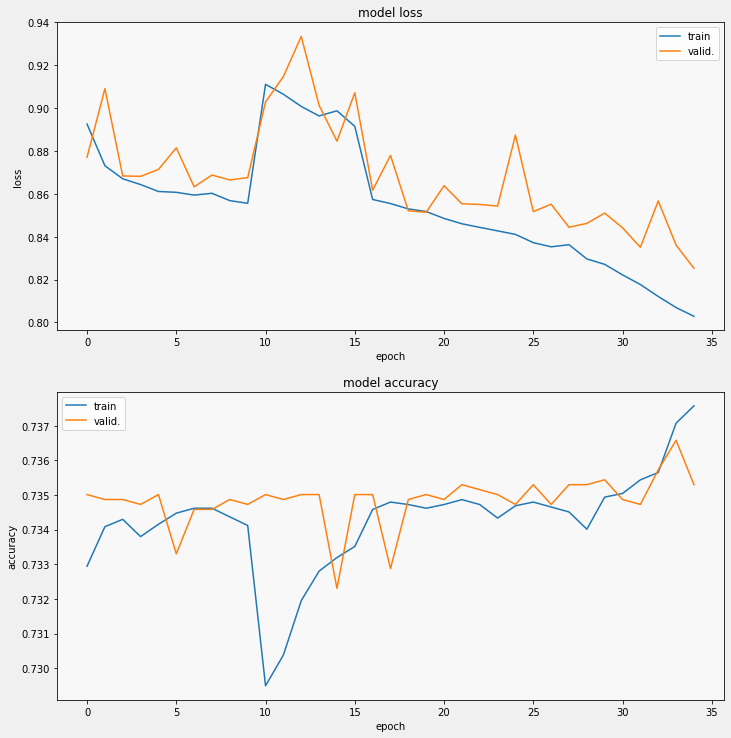

In [ ]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['acc'], 
    history.history['val_acc'], 
    'accuracy', 212)